# Playground

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from typing import List, Set, Dict, Tuple, Optional, Any
from collections import defaultdict

import pandas as pd
import seaborn as sns
import numpy as np

import math 
import torch
from torch import nn, Tensor
from torch.nn.functional import softplus, relu
from torch.distributions import Distribution, Normal
from torch.utils.data import DataLoader, Dataset

from gmfpp.utils.data_preparation import *
from gmfpp.utils.data_transformers import *
from gmfpp.utils.plotting import *

from gmfpp.models.ReparameterizedDiagonalGaussian import *
from gmfpp.models.CytoVariationalAutoencoder import *
from gmfpp.models.VariationalAutoencoder import *
from gmfpp.models.ConvVariationalAutoencoder import *
from gmfpp.models.VariationalInference import *
from gmfpp.models.LoadModels import *

In [5]:
constant_seed()

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Refactor

## Load data

In [7]:
metadata_all = read_metadata("./data/all/metadata.csv")

In [8]:
metadata = metadata_all[:2000]

In [9]:
metadata = shuffle_metadata(metadata)
metadata_train, metadata_validation = split_metadata(metadata, split_fraction = .90)

In [10]:
metadata.shape

(2000, 19)

In [11]:
relative_path = get_relative_image_paths(metadata)
image_paths = ["./data/all/" + path for path in relative_path]

In [12]:
images = load_images(image_paths, verbose=True, log_every=10000)

11:41:45 | loaded 0/2000 images (0.00%).
11:41:46 | loaded 2000/2000 images (100.00%).


## Normalize data

In [13]:
#normalize_every_image_channels_seperately_inplace(images)
normalize_channels_inplace(images)

In [14]:
channel_first = view_channel_dim_first(images)
for i in range(channel_first.shape[0]):
    channel = channel_first[i]
    print("channel {} interval: [{:.2f}; {:.2f}]".format(i, torch.min(channel), torch.max(channel)))

channel 0 interval: [0.02; 1.00]
channel 1 interval: [0.01; 1.00]
channel 2 interval: [0.01; 1.00]


## Prepare datasets

In [15]:
class SingleCellDataset(Dataset):
    
    def __init__(self, metadata: pd.DataFrame, images: torch.Tensor, label_to_id: Dict[str, int]):
        self.metadata = metadata
        self.label_to_id = label_to_id
        self.images = images
        
    def __len__(self):
        return self.metadata.shape[0]

    def __getitem__(self, idx):
        row = self.metadata.iloc[idx]
        
        image_id = row.name
        image = self.images[image_id]
        
        label_name = row["moa"]
        label = self.label_to_id[label_name]
        
        return image.detach(), label

In [16]:
mapping = get_MOA_to_id()
train_set = SingleCellDataset(metadata_train, images, mapping)
validation_set = SingleCellDataset(metadata_validation, images, mapping)

In [17]:
len(train_set)

1801

## VAE

In [48]:
# start another training session
vae, validation_data, training_data, VAE_settings = initVAEmodel(latent_features= 256,
                                                                    beta = 1.,
                                                                    num_epochs = 1000,
                                                                    batch_size = min(32, len(train_set)),
                                                                    learning_rate = 1e-3,
                                                                    weight_decay = 10e-4,
                                                                    image_shape = np.array([3, 68, 68]))

In [18]:
#Or load an old
#vae, validation_data, training_data, VAE_settings = LoadVAEmodel("model_dump", '2022-11-21 - 13-30-35')
vae, validation_data, training_data, VAE_settings = LoadVAEmodel("./model_dump", '2022-11-25 - 06-53-47')

In [19]:
vae = vae.to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=VAE_settings['learning_rate'], weight_decay=VAE_settings['weight_decay'])

vi = VariationalInference(beta=VAE_settings['beta'])

In [20]:
train_loader = DataLoader(train_set, batch_size=VAE_settings['batch_size'], shuffle=True, num_workers=0, drop_last=True)
validation_loader = DataLoader(validation_set, batch_size=len(validation_set), shuffle=False, num_workers=0, drop_last=False)

In [ ]:
print_every = 1

num_epochs = VAE_settings['num_epochs']
batch_size = VAE_settings['batch_size']

for epoch in range(num_epochs):

    training_epoch_data = defaultdict(list)
    
    vae.train()

    for x, _ in train_loader:
        x = x.to(device)
        
        # perform a forward pass through the model and compute the ELBO
        loss, diagnostics, outputs = vi(vae, x)

        optimizer.zero_grad()
        loss.backward()
        nn.utils.clip_grad_norm_(vae.parameters(), 10_000)
        optimizer.step()

        for k, v in diagnostics.items():
            training_epoch_data[k] += [v.mean().item()]


    for k, v in training_epoch_data.items():
        training_data[k] += [np.mean(training_epoch_data[k])]

    with torch.no_grad():
        vae.eval()
        
        validation_epoch_data = defaultdict(list)
        
        for x, _ in validation_loader:
            x = x.to(device)
          
            loss, diagnostics, outputs = vi(vae, x)
            
            for k, v in diagnostics.items():
                validation_epoch_data[k] += [v.mean().item()]

        for k, v in diagnostics.items():
            validation_data[k] += [np.mean(validation_epoch_data[k])]
        
    if epoch % print_every == 0:
        print(f"epoch: {epoch}/{num_epochs}")  
        print("training | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(training_epoch_data["elbo"]), np.mean(training_epoch_data["log_px"]), np.mean(training_epoch_data["kl"])))
        print("validation | elbo: {:2f}, log_px: {:.2f}, kl: {:.2f}:".format(np.mean(validation_data["elbo"]), np.mean(validation_data["log_px"]), np.mean(validation_data["kl"])))    


In [144]:
print(VAE_settings)

{'latent_features': 256, 'beta': 1.0, 'num_epochs': 10000, 'batch_size': 32, 'learning_rate': 0.001, 'weight_decay': 0.001, 'image_shape': array([ 3, 68, 68])}


In [145]:
######### Save VAE parameters #########
cprint("Save VAE parameters")
create_directory("dump/parameters")
datetime = get_datetime()
torch.save(vae.state_dict(), "dump/parameters/vae_parameters_{}.pt".format(datetime))
torch.save(validation_data, "dump/parameters/validation_data_{}.pt".format(datetime))
torch.save(training_data, "dump/parameters/training_data_{}.pt".format(datetime))
torch.save(VAE_settings, "dump/parameters/VAE_settings_{}.pt".format(datetime))

13:52:28 | Save VAE parameters


In [ ]:
plot_VAE_performance(**training_data, file='dump/images/training_data.png', title='VAE - learning')
plot_VAE_performance(**validation_data, file='dump/images/validation_data.png', title='VAE - validation')

## Compare reconstruction and original image

In [26]:
x, _ = validation_set[1]

In [29]:
x.shape

torch.Size([3, 68, 68])

In [30]:
def img_saturate(img: torch.Tensor) -> torch.Tensor:
    return img / torch.max(img)

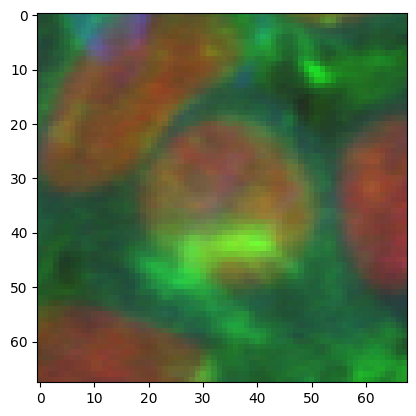

In [32]:
plot_image(img_saturate(x))

In [33]:
vae.eval() # because of batch normalization
outputs = vae(x[None,:,:,:])
px = outputs["px"]

x_reconstruction = px.sample()
x_reconstruction = x_reconstruction[0]

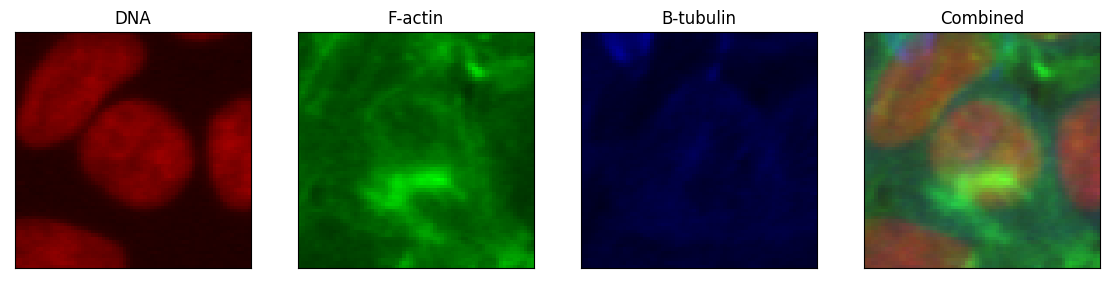

In [36]:
plot_image_channels(img_saturate(x))

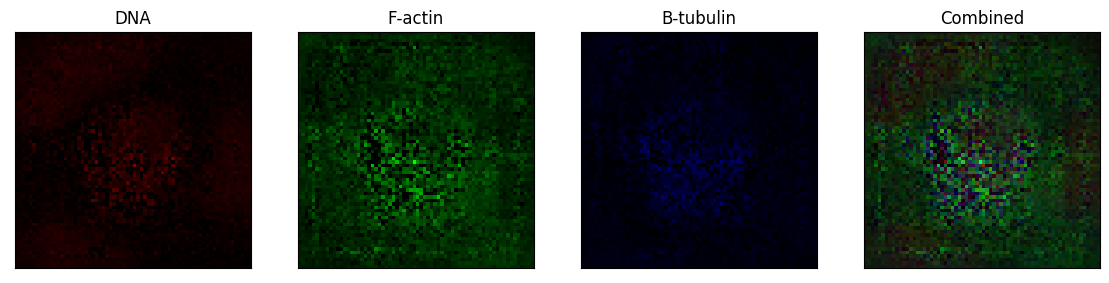

In [37]:
plot_image_channels(img_saturate(x_reconstruction))

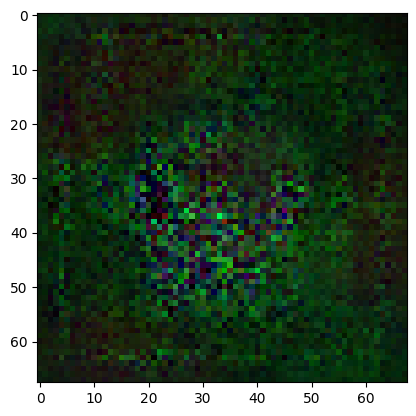

In [38]:
plot_image(img_saturate(clip_image_to_zero_one(x_reconstruction)))

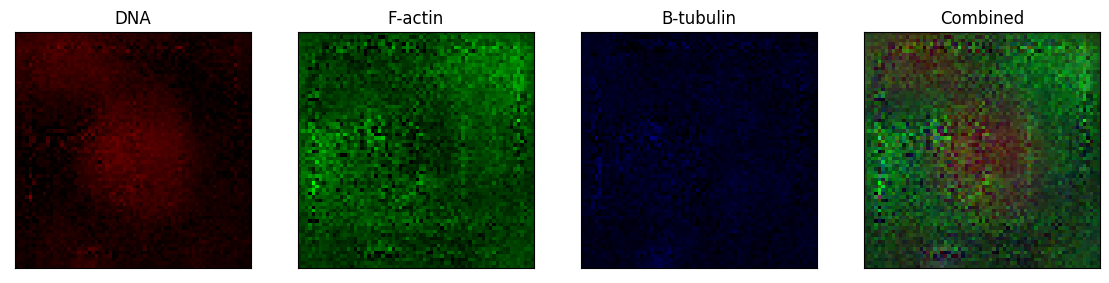

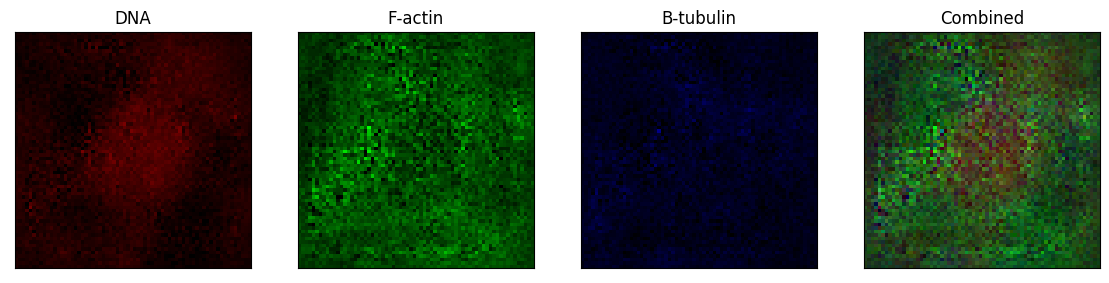

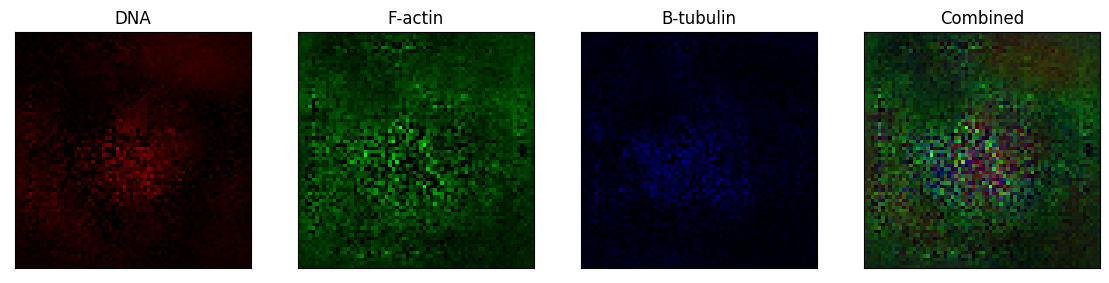

In [39]:
n = 3
for i in range(n):
    x, y = train_set[i]    
    #x = x.to(device)
    
    plot_image_channels(x, file="dump/images/x_{}.png".format(i))
   
    outputs = vae(x[None,:,:,:])
    px = outputs["px"]
    
    x_reconstruction = px.sample()
    x_reconstruction = x_reconstruction[0]
    plot_image_channels(img_saturate(x_reconstruction))


## Downstream Classification

In [90]:
def get_plate_and_well_indices(metadata: pd.DataFrame) -> Dict[str, list]:
    plates_and_wells = np.array(metadata[['Image_Metadata_Plate_DAPI','Image_Metadata_Well_DAPI']])
    result = defaultdict(list)

    for i in range(plates_and_wells.shape[0]):
        plate, well = plates_and_wells[i]
        result[(plate, well)] += [i]
        
    return result

In [91]:
class NeuralNetwork(nn.Module):
    
    def __init__(self, n_classes: int = 13):
        super(NeuralNetwork, self).__init__()
        
        self.net = nn.Sequential(
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_classes))

    def forward(self, x):
        logits = self.net(x)
        return logits

    
N_classes = len(mapping)
classifier = NeuralNetwork(N_classes).to(device)
print(classifier)

NeuralNetwork(
  (net): Sequential(
    (0): Linear(in_features=256, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=13, bias=True)
  )
)


In [92]:
# VAE
image_shape = np.array([3, 68, 68])
latent_features = 256
vae = CytoVariationalAutoencoder(image_shape, latent_features).to(device) # @TODO: load trained parameters

In [19]:
def extract_well_metadata(metadata: pd.DataFrame, plate_and_well_indices: Dict[Tuple[str, str], list]) -> pd.DataFrame:
    data = defaultdict(list)

    for plate_and_well in plate_and_well_indices:
        indices = plate_and_well_indices[plate_and_well]
        index = indices[0] # just use the first sample, since they all have undergone the same treatment

        row = metadata.loc[index]
        
        plate, well = plate_and_well
        
        data["Image_Metadata_Plate_DAPI"] += [plate]
        data["Image_Metadata_Well_DAPI"] += [well]
        data["Image_Metadata_Compound"] += [row["Image_Metadata_Compound"]]
        data["Image_Metadata_Concentration"] += [row["Image_Metadata_Concentration"]]
        data["moa"] += [row["moa"]]

    well_metadata = pd.DataFrame(data)
        
    return well_metadata

In [20]:
def get_well_profiles(vae: nn.Module, metadata: pd.DataFrame, images: torch.Tensor) -> torch.Tensor:
    vae.eval()
    
    plate_and_well_indices = get_plate_and_well_indices(metadata)
    well_metadata = extract_well_metadata(metadata, plate_and_well_indices)
    
    well_profiles = torch.empty((len(plate_and_well_indices), vae.latent_features))
    
    batch_size = 64 # we need to batch them to handle memory issues...
    
    for i, plate_and_well in enumerate(plate_and_well_indices):
        indices = plate_and_well_indices[plate_and_well]
        x = images[indices]
        x = x.to(device)
        
        z = torch.zeros(vae.latent_features)

        batch_offset = np.arange(start=0, stop=len(x), step=batch_size)
        for j in range(batch_offset.shape[0] - 1):
            start = batch_offset[j]
            end = batch_offset[j+1]
            
            outputs = vae(x[start:end])
            z += torch.sum(outputs["z"])
        
        # last batch
        outputs = vae(x[batch_offset[-1]:])   
        z += torch.sum(outputs["z"])
        
        well_profiles[i] = z.cpu() / len(indices)
        
    return well_profiles, well_metadata

In [21]:
%%time
well_profiles, well_metadata = get_well_profiles(vae, metadata, images)

CPU times: total: 1min 51s
Wall time: 28.7 s


In [22]:
well_metadata.head()

,Image_Metadata_Plate_DAPI,Image_Metadata_Well_DAPI,Image_Metadata_Compound,Image_Metadata_Concentration,moa
0,Week10_40111,B02,DMSO,0.0,DMSO
1,Week10_40111,B11,taxol,0.3,Microtubule stabilizers
2,Week10_40111,C02,DMSO,0.0,DMSO


In [23]:
def count_num_correct(y_pred, y_true):
    return torch.sum(y_pred == y_true).item()

In [93]:
# Classifier
N_classes = len(mapping)
classifier = NeuralNetwork(N_classes).to(device)

# Training
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(classifier.parameters(), lr=1e-2)

num_epochs = 10
batch_size = 32

In [25]:
def extract_metadata_with_compound(metadata: pd.DataFrame, compound: str) -> pd.DataFrame:
    return metadata[metadata["Image_Metadata_Compound"] == compound]

In [26]:
def remove_metadata_subset(metadata: pd.DataFrame, subset: pd.DataFrame) -> pd.DataFrame:
    return metadata[~metadata.index.isin(subset.index)]

In [104]:
metadata_test = extract_metadata_with_compound(well_metadata, "taxol")
metadata_train_all = remove_metadata_subset(well_metadata, metadata_test)
metadata_train, metadata_validation = split_metadata(metadata_train_all, split_fraction = .49)

mapping = get_MOA_to_id()
train_set = SingleCellDataset(metadata_train, well_profiles, mapping)
validation_set = SingleCellDataset(metadata_validation, well_profiles, mapping)
test_set = SingleCellDataset(metadata_test, well_profiles, mapping)

In [105]:
train_loader = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0, drop_last=False)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=False, num_workers=0, drop_last=False)

In [109]:
train_loss = []
train_accuracy = []

validation_loss = []
validation_accuracy = []

for epoch in range(num_epochs):
    print(f"epoch: {epoch}/{num_epochs}")    

    train_epoch_loss = []
    train_epoch_accuracy = []
    
    classifier.train()
    
    train_correct = 0
    train_num_predictions = 0
    
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        prediction_prob = classifier(x)
        loss = loss_fn(prediction_prob, y)
        
        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        N = len(x)
        train_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        train_correct += count_num_correct(pred, y.detach())
        
        train_epoch_loss.append(loss.detach().item())
        
    epoch_mean_loss = np.mean(train_epoch_loss)
    train_loss.append(epoch_mean_loss)
    train_accuracy.append(train_correct / train_num_predictions)
    
    print("training | loss: {:.2f}".format(epoch_mean_loss))
    
    
    validation_epoch_loss = []
    classifier.eval()
    
    validation_correct = 0
    validation_num_predictions = 0
    
    for x, y in validation_loader:
        x = x.to(device)
        y = y.to(device)
        
        prediction_prob = classifier(x)
        loss = loss_fn(prediction_prob, y)
        
        validation_epoch_loss.append(loss.detach().item())
        
        N = len(x)
        validation_num_predictions += N
        pred = torch.argmax(prediction_prob, dim=1)
        validation_correct += count_num_correct(pred, y)

    epoch_mean_loss = np.mean(validation_epoch_loss)
    validation_loss.append(epoch_mean_loss)
    validation_accuracy.append(validation_correct / validation_num_predictions)
   
        
    print("validation | loss: {:.2f}".format(epoch_mean_loss))

epoch: 0/10
training | loss: 0.03
validation | loss: 2.26
epoch: 1/10
training | loss: 0.03
validation | loss: 2.26
epoch: 2/10
training | loss: 0.03
validation | loss: 2.25
epoch: 3/10
training | loss: 0.02
validation | loss: 2.25
epoch: 4/10
training | loss: 0.02
validation | loss: 2.25
epoch: 5/10
training | loss: 0.02
validation | loss: 2.25
epoch: 6/10
training | loss: 0.02
validation | loss: 2.25
epoch: 7/10
training | loss: 0.02
validation | loss: 2.25
epoch: 8/10
training | loss: 0.02
validation | loss: 2.25
epoch: 9/10
training | loss: 0.02
validation | loss: 2.25


In [110]:
def plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy):
    fig, axs = plt.subplots(1, 2, figsize=(14,6), constrained_layout = True)
    fig.suptitle("Classifier - learning", fontsize=16)

    ax1 = axs[0]
    ax1.grid()
    ax1.plot(train_loss)
    ax1.plot(validation_loss)
    ax1.legend(["train", "validation"])
    ax1.set_ylabel("loss")
    ax1.set_xlabel("epoch")

    ax2 = axs[1]
    ax2.grid()
    ax2.plot(train_accuracy)
    ax2.plot(validation_accuracy)
    ax2.legend(["train", "validation"])
    ax2.set_ylabel("accuracy")
    ax2.set_xlabel("epoch")

In [ ]:
plot_classifier_performance(train_loss, train_accuracy, validation_loss, validation_accuracy)

## @TODO
- Look at latent representation
    - How does changing one latent variable change the image reconstruction?
    - How similiar are images in the latent space (cosine-simularity)

In [253]:
def print_MOA_distribution(metadata: pd.DataFrame):
    moa_types = get_MOA_types()
    for moa in moa_types:
        count = np.sum(metadata["moa"] == moa)
        percentage = count / len(metadata)
        print("{} - {:.3f}".format(moa, percentage))

In [254]:
def extract_indices_for_each_MOA(metadata: pd.DataFrame) -> Dict[str, np.ndarray]:
    moa_types = get_MOA_types()
    result = {}
    
    for moa in moa_types:
        mask = np.array(metadata["moa"] == moa)
        result[moa] = np.array(metadata.index[mask])
        
    return result

In [255]:
def flatten_MOA_indices(moa_indices: Dict[str, np.ndarray]):
    return np.concatenate([moa_indices[moa] for moa in moa_indices])

In [256]:
def extract_metadata_from_indices(metadata: pd.DataFrame, indices: np.ndarray) -> pd.DataFrame:
    return metadata.loc[indices]

In [257]:
def shuffle_MOA_indices_inplace(moa_indices: Dict[str, np.ndarray]):
    for moa in moa_indices:
        np.random.shuffle(moa_indices[moa])

In [258]:
def count_MOA_samples(metadata: pd.DataFrame):
    moa_types = get_MOA_types()
    indices = extract_indices_for_each_MOA(metadata)
    result = {}
    
    for moa in indices:
        result[moa] = indices[moa].shape[0]
        
    return result

In [72]:
def get_MOA_types() -> List[str]:
    return list(get_MOA_to_id())

In [260]:
class MoaBalancedBatchGenerator:
    
    def __init__(self, moa_indices: Dict[str, np.ndarray], images: torch.Tensor, metadata: pd.DataFrame, num_moa_type_per_batch: int = 1):
        self.moa_indices = moa_indices
        self.batch_size = num_moa_type_per_batch * len(moa_indices)
        self.num_moa_type_per_batch = num_moa_type_per_batch
        self.images = images
        self.metadata = metadata
    
    def next_indices(self) -> np.ndarray:
        result = np.empty(self.batch_size, dtype=np.int64)
        
        for i, moa in enumerate(moa_indices):
            pick = np.random.choice(moa_indices[moa], self.num_moa_type_per_batch, replace=False)
            
            start = i * self.num_moa_type_per_batch
            end = start + self.num_moa_type_per_batch
            result[start:end] = pick
            
        return result
    
    def __iter__(self):
        return self

    def __next__(self):
        indices = self.next_indices()
        X, y = extract_batch_from_indices(indices, self.images, self.metadata)
        return X, y

In [15]:
def get_MOA_to_id() -> Dict[str, int]:
    return {'Actin disruptors': 0,
            'Aurora kinase inhibitors': 1,
            'Cholesterol-lowering': 2,
            'DMSO': 3,
            'DNA damage': 4,
            'DNA replication': 5,
            'Eg5 inhibitors': 6,
            'Epithelial': 7,
            'Kinase inhibitors': 8,
            'Microtubule destabilizers': 9,
            'Microtubule stabilizers': 10,
            'Protein degradation': 11,
            'Protein synthesis': 12}

In [261]:
def extract_images_from_indices(indices: np.ndarray, images: torch.Tensor) -> torch.Tensor:        
    return images[indices].clone()

In [262]:
def extract_MOA_ids_from_indices(indices: np.ndarray, metadata: pd.DataFrame) -> torch.Tensor:
    moa_to_id = get_MOA_to_id()
    rows = metadata["moa"].loc[indices]
    return torch.tensor([moa_to_id[row] for row in rows])

In [263]:
def extract_images_from_metadata_indices(indices: np.ndarray, images: torch.Tensor) -> torch.Tensor:
    return images[indices]

In [264]:
def get_MOA_balanced_metadata_subset(all_metadata: pd.DataFrame, num_samples_in_each_moa: int) -> pd.DataFrame:
    moa_indices = extract_indices_for_each_MOA(all_metadata)
    
    for moa in moa_indices:
        assert len(moa_indices[moa]) >= num_samples_in_each_moa, "MOA {} has only {} samples, but asked for {} samples".format(moa, len(moa_indices[moa]), num_samples_in_each_moa)
        moa_indices[moa] = moa_indices[moa][:num_samples_in_each_moa]
    
    indices = flatten_MOA_indices(moa_indices)
    metadata = extract_metadata_from_indices(all_metadata, indices)
    
    return metadata

In [23]:
metadata = get_MOA_balanced_metadata_subset(metadata_all, num_samples_in_each_moa=20)
metadata = metadata.reset_index(drop=True)

In [24]:
print_MOA_distribution(metadata)

Actin disruptors - 0.077
Aurora kinase inhibitors - 0.077
Cholesterol-lowering - 0.077
DMSO - 0.077
DNA damage - 0.077
DNA replication - 0.077
Eg5 inhibitors - 0.077
Epithelial - 0.077
Kinase inhibitors - 0.077
Microtubule destabilizers - 0.077
Microtubule stabilizers - 0.077
Protein degradation - 0.077
Protein synthesis - 0.077


In [25]:
metadata_test = get_MOA_balanced_metadata_subset(metadata, num_samples_in_each_moa=2)
metadata_train_all = metadata[~metadata.index.isin(metadata_test.index)]
metadata_validation = get_MOA_balanced_metadata_subset(metadata_train_all, num_samples_in_each_moa=2)
metadata_training = metadata_train_all[~metadata_train_all.index.isin(metadata_validation.index)]

In [95]:
#moa_indices = extract_indices_for_each_MOA(metadata_training)
#shuffle_MOA_indices_inplace(moa_indices)

In [28]:
def extract_batch_from_indices(indices: np.ndarray, images: torch.Tensor, metadata: pd.DataFrame) -> Tuple[torch.Tensor, torch.Tensor]:
    batch_images = extract_images_from_metadata_indices(indices, images)
    batch_labels = extract_MOA_ids_from_indices(indices, metadata)
    return batch_images, batch_labels

In [ ]:
moa_indices = extract_indices_for_each_MOA(metadata_training)
batchGenerator = MoaBalancedBatchGenerator(moa_indices, images, metadata, num_moa_type_per_batch=4)

In [125]:
%%time
max_iterations = 80_000

i = 0
for i in range(max_iterations):
    X, y = next(batchGenerator)
    

print("done")

done
CPU times: total: 10min 16s
Wall time: 2min 34s
